<a href="https://colab.research.google.com/github/arun4589/ML/blob/main/transfer_learning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:10<00:00, 238MB/s]
100% 1.06G/1.06G [00:10<00:00, 109MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Dropout
from keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

In [5]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)
valid_ds=keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [6]:
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)
  return image,label

train_ds=train_ds.map(process)
valid_ds=valid_ds.map(process)
# normalizing all images data between 0 to 1

In [7]:
from keras.applications.vgg16 import VGG16
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [9]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [10]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [12]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
history =model.fit(train_ds,epochs=10,validation_data=valid_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 105ms/step - accuracy: 0.8412 - loss: 0.3366 - val_accuracy: 0.9348 - val_loss: 0.1612
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 99ms/step - accuracy: 0.9421 - loss: 0.1458 - val_accuracy: 0.9432 - val_loss: 0.1369
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9592 - loss: 0.1055 - val_accuracy: 0.9496 - val_loss: 0.1261
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9745 - loss: 0.0721 - val_accuracy: 0.9528 - val_loss: 0.1249
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9843 - loss: 0.0521 - val_accuracy: 0.9532 - val_loss: 0.1237
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9895 - loss: 0.0344 - val_accuracy: 0.9548 - val_loss: 0.1321
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9942 - loss: 0.0233 - val_accuracy: 0.9388 - val_loss: 0.2095
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.9961 - loss: 0.0168 

Text(0.5, 0, 'epoch')

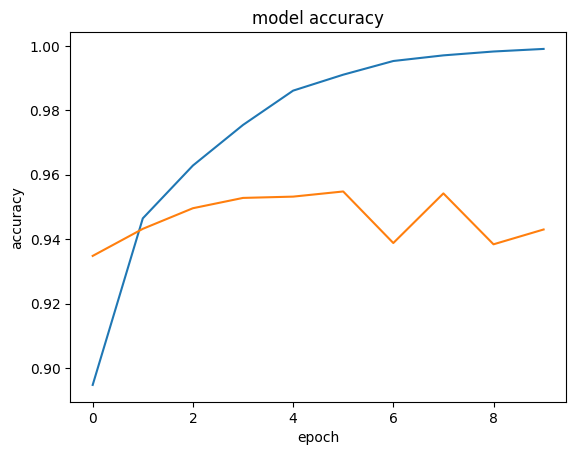

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

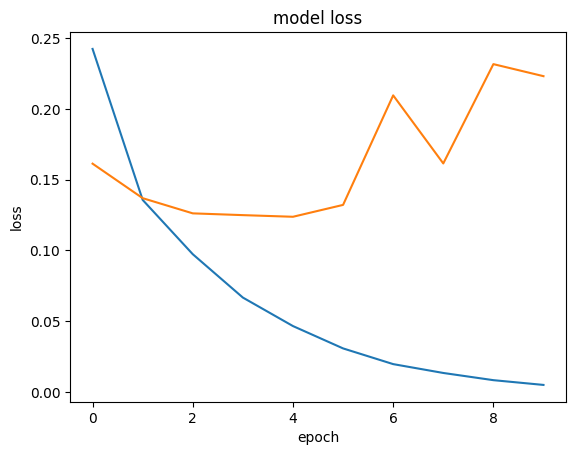

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [16]:
# we can also use data augmentation to reduce overfitting here also